In [1]:
%matplotlib widget

In [2]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import pathlib
import pandas
from pykern import pkyaml
from sirepo.template import madx_parser
from rsbeams.rsdata.SDDS import readSDDS
from scipy import constants

# Load Results 


## MADX

In [84]:
madx_particle_file = 'madx/ptc_track.file.tfsone'


In [85]:
mp = madx_parser.parse_tfs_file(
        madx_particle_file
    )
    

In [86]:
madx_particles = {}
for k, v in mp.items():
    madx_particles[k] = np.array(v, float)

In [87]:
madx_twiss_file = 'madx/twiss.file.tfs'

In [88]:
madx_twiss = madx_parser.parse_tfs_file(
        madx_twiss_file
    )

## elegant

In [8]:
elegant_particle_file = readSDDS('elegant_matched/run_setup.output.sdds')
elegant_particle_file.read()
elegant_particles = elegant_particle_file.columns.squeeze()

elegant_sigma_file = readSDDS('elegant_matched/run_setup.sigma.sdds')
elegant_sigma_file.read()
elegant_sigma = elegant_sigma_file.columns.squeeze()

elegant_twiss_file = readSDDS('elegant_matched/twiss_output.filename.sdds')
elegant_twiss_file.read()
elegant_twiss = elegant_twiss_file.columns.squeeze()

# ImpactX

In [9]:
# impactx_sigma = pandas.read_csv('impactx_from_elegant_matching/diags//reduced_beam_characteristics.0.0', delimiter=' ')
# impactx_particles = pandas.read_hdf('impactx_from_elegant_matching/diags/final_distribution.h5')

In [10]:
impactx_sigma = pandas.read_csv('impactx_local/reduced_beam_characteristics.0.0', delimiter=' ')
impactx_particles = pandas.read_hdf('impactx_local/final_distribution.h5')

# Plots

In [89]:
partitions = np.where(np.diff(madx_particles['number']) !=1)[0]

madx_s = []
madx_sigma_x = []
madx_sigma_y = []

for i in range(partitions.size):
    start_index = 0 if i == 0 else (partitions[i-1]+1)
    end_index = partitions[i]+1
    _s = madx_particles['s'][start_index:end_index]
    _x = madx_particles['x'][start_index:end_index]
    _y = madx_particles['y'][start_index:end_index]
    _px = madx_particles['px'][start_index:end_index]
    
    assert np.all(_s==_s[0]), print(i)
    
    madx_sigma_x.append(np.std(_x))
    madx_sigma_y.append(np.std(_y))
    madx_s.append(_s[0])

In [90]:
madx_s = np.array(madx_s)
madx_sigma_x = np.array(madx_sigma_x)
madx_sigma_y = np.array(madx_sigma_y)

## Sigma
Compare beam envelope from particle tracking

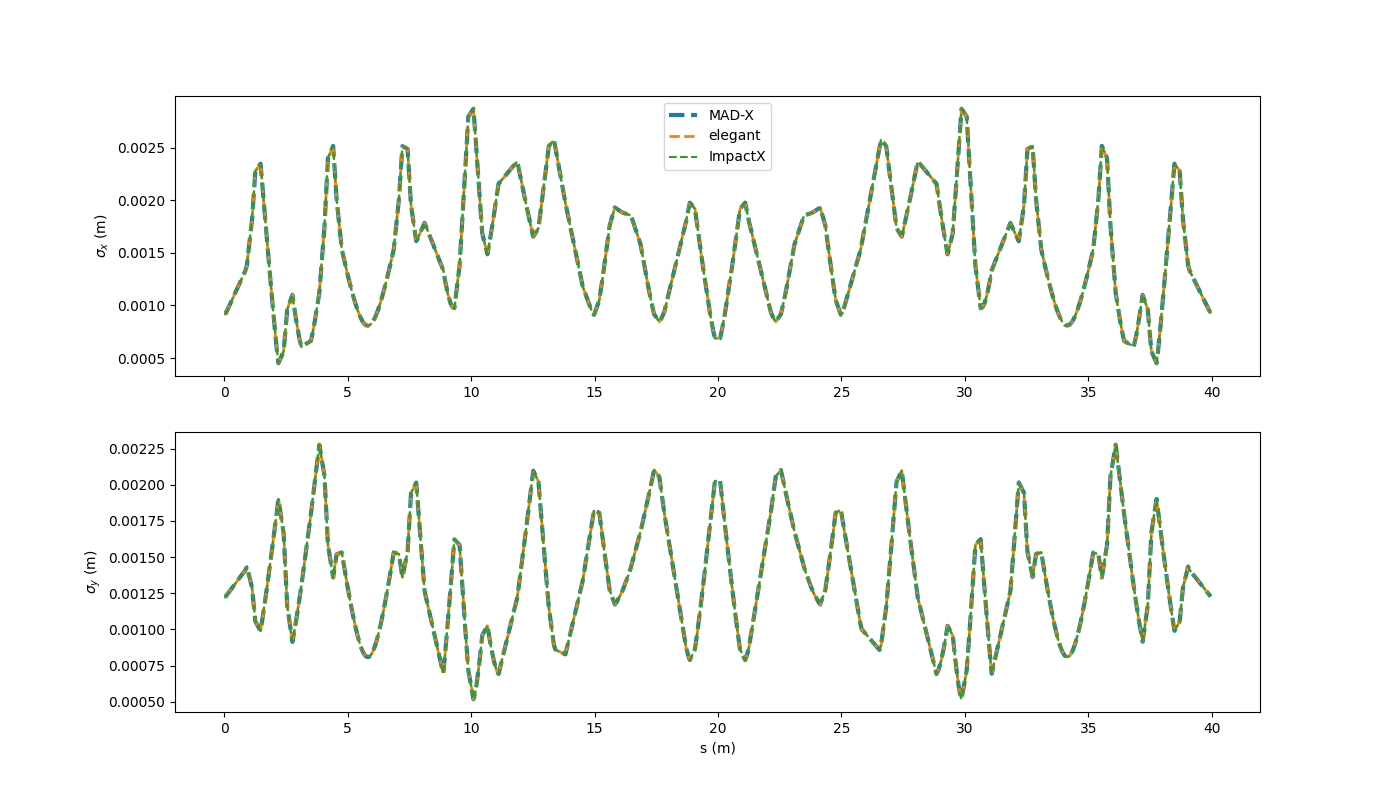

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.set_ylabel(r'$\sigma_x$ (m)')
ax1.plot(madx_s, madx_sigma_x, '--', label=r'MAD-X', linewidth=3)
ax1.plot(elegant_sigma['s'], elegant_sigma['Sx'], '--', label=r'elegant', linewidth=2)
ax1.plot(impactx_sigma['s'].values, impactx_sigma['sig_x'].values, '--', label='ImpactX')

ax2.set_ylabel(r'$\sigma_y$ (m)')
ax2.plot(madx_s, madx_sigma_y, '--', label=r'MAD-X', linewidth=3)
ax2.plot(elegant_sigma['s'], elegant_sigma['Sy'], '--', label=r'elegant', linewidth=2)
ax2.plot(impactx_sigma['s'].values, impactx_sigma['sig_y'].values, '--', label='ImpactX')

ax2.set_xlabel('s (m)')
ax1.legend()
plt.show()

## Twiss
Compares Twiss beta values calculated in several ways

- `MAD-X Twiss` and `elegant Twiss` this is propagation of the Twiss parameters directly. No particle tracking is involved in the calculation
- `elegant particle` the beam envelope and emittance from particle tracking are used with the dispersion to calculate the Twiss (Note: elegant also does this calculation internally, see the `betaxBeam` value in the sigma file.)
- `ImpactX` Twiss calculated internally by ImpactX, from particle tracking

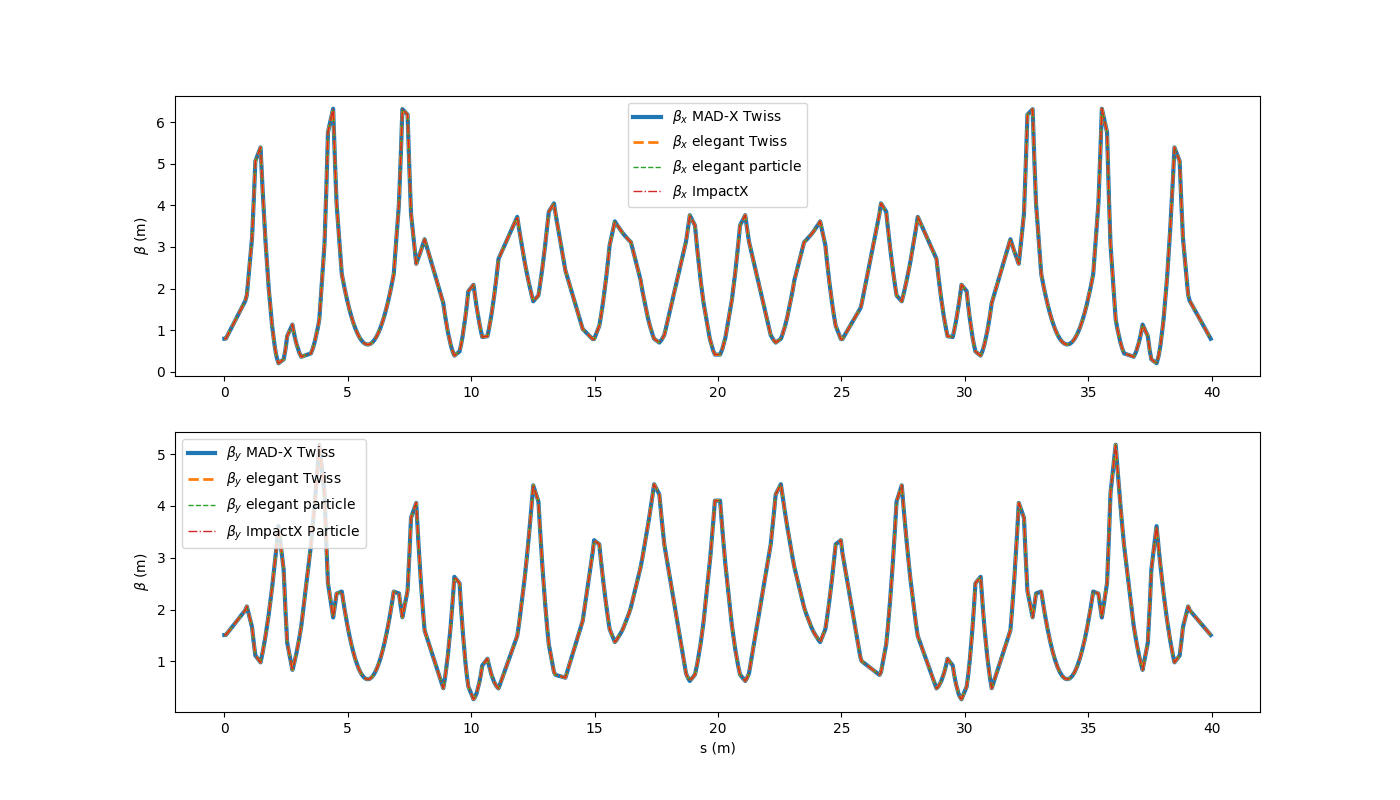

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

ax1.plot(np.array(madx_twiss['s'], float), np.array(madx_twiss['betx'], float), label=r'$\beta_x$ MAD-X Twiss', linewidth=3)
ax1.plot(elegant_twiss['s'], elegant_twiss['betax'], '--', label=r'$\beta_x$ elegant Twiss', linewidth=2)
ax1.plot(elegant_twiss['s'], 
         (elegant_sigma['Sx']**2 - elegant_twiss['etax']**2*elegant_sigma['Sdelta']**2) / elegant_sigma['ecx'], '--', label=r'$\beta_x$ elegant particle', linewidth=1)
ax1.plot(impactx_sigma['s'].values, impactx_sigma['beta_x'].values, '-.', label=r'$\beta_x$ ImpactX', linewidth=1)

ax2.plot(np.array(madx_twiss['s'], float), np.array(madx_twiss['bety'], float), label=r'$\beta_y$ MAD-X Twiss', linewidth=3)
ax2.plot(elegant_twiss['s'], elegant_twiss['betay'], '--', label=r'$\beta_y$ elegant Twiss', linewidth=2)
ax2.plot(elegant_twiss['s'], 
         (elegant_sigma['Sy']**2 - elegant_twiss['etay']**2*elegant_sigma['Sdelta']**2) / elegant_sigma['ecy'], '--', label=r'$\beta_y$ elegant particle', linewidth=1)
ax2.plot(impactx_sigma['s'].values, impactx_sigma['beta_y'].values, '-.', label=r'$\beta_y$ ImpactX Particle', linewidth=1)

ax2.set_xlabel('s (m)')
for ax in (ax1, ax2):
    ax.set_ylabel(r'$\beta$ (m)')
    ax.legend()

plt.show()

## Tracking

In [93]:
madx_particles['x'][-5000:].shape

(5000,)

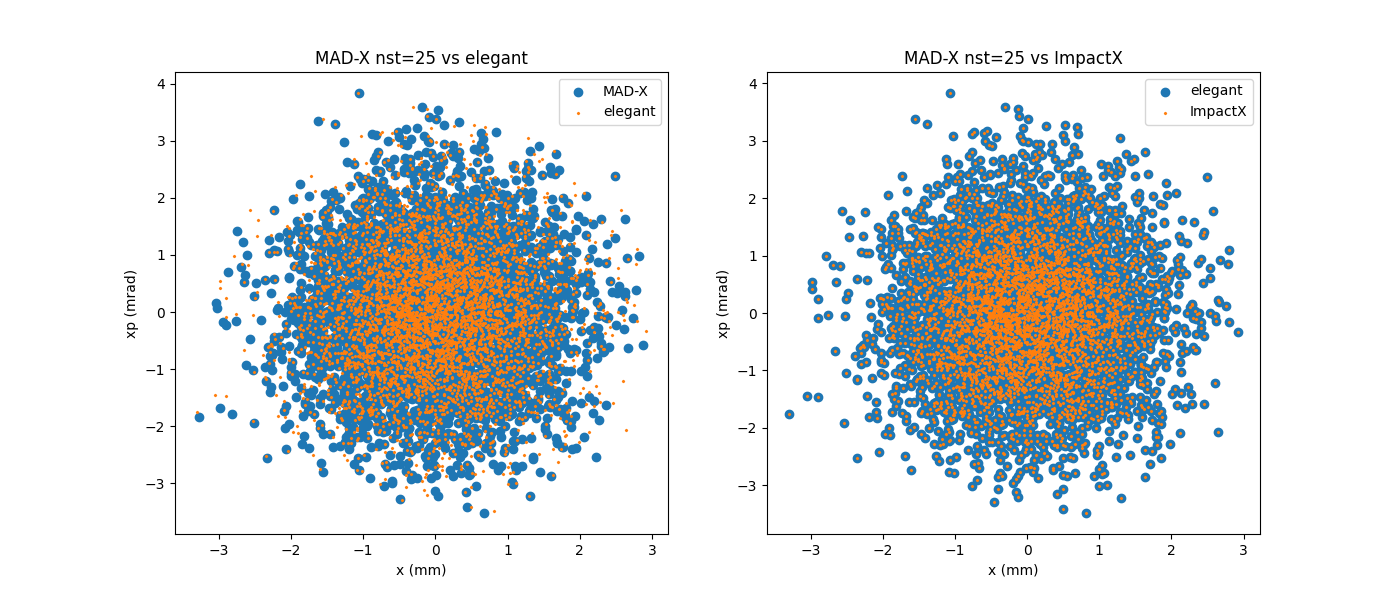

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(madx_particles['x'][-5000:] * 1e3, madx_particles['px'][-5000:] * 1e3, label='MAD-X')
ax1.scatter(elegant_particles['x'] * 1e3, elegant_particles['xp'] * 1e3, marker='x', s=2, label='elegant')
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('xp (mrad)')
ax1.legend()
ax1.set_title('MAD-X nst=25 vs elegant')

ax2.scatter(elegant_particles['x'] * 1e3, elegant_particles['xp'] * 1e3, label='elegant')
ax2.scatter(impactx_particles['position_x'] * 1e3, impactx_particles['momentum_x'] * 1e3, marker='x', s=2, label='ImpactX')
ax2.set_xlabel('x (mm)')
ax2.set_ylabel('xp (mrad)')
ax2.legend()
ax2.set_title('MAD-X nst=25 vs ImpactX')

plt.show()

In [70]:
madx_particles['y'].size / 5000

546.0

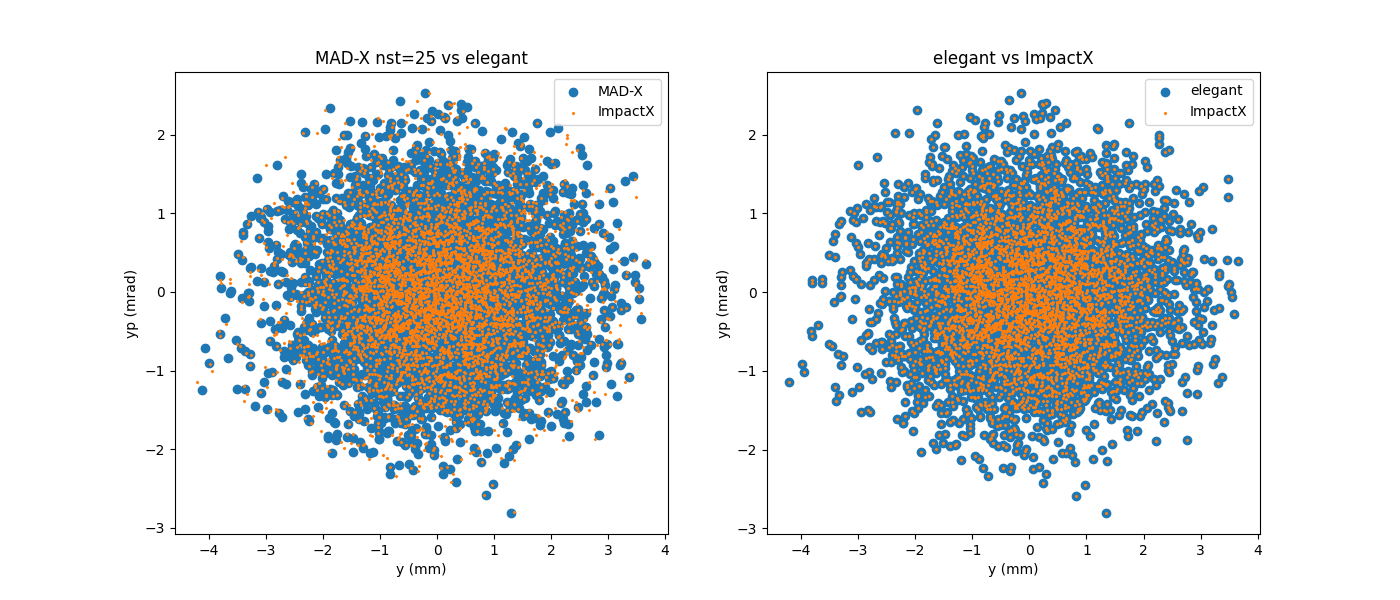

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(madx_particles['y'][-5000:] * 1e3, madx_particles['py'][-5000:] * 1e3, label='MAD-X')
ax1.scatter(elegant_particles['y'] * 1e3, elegant_particles['yp'] * 1e3, marker='x', s=2, label='ImpactX')
ax1.set_xlabel('y (mm)')
ax1.set_ylabel('yp (mrad)')
ax1.legend()
ax1.set_title('MAD-X nst=25 vs elegant')

ax2.scatter(elegant_particles['y'] * 1e3, elegant_particles['yp'] * 1e3,  label='elegant')
ax2.scatter(impactx_particles['position_y'] * 1e3, impactx_particles['momentum_y'] * 1e3, marker='x', s=2, label='ImpactX')
ax2.set_xlabel('y (mm)')
ax2.set_ylabel('yp (mrad)')
ax2.legend()
ax2.set_title('elegant vs ImpactX')

plt.show()

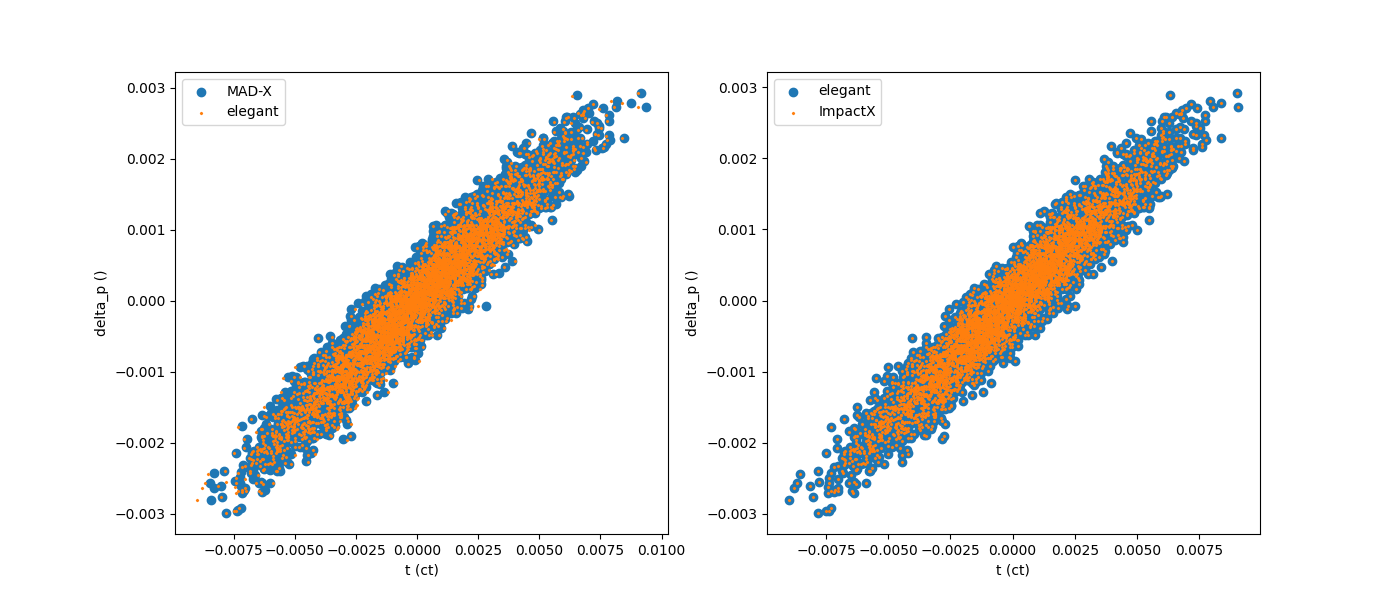

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(-madx_particles['t'][-5_000:] - 0.0003, madx_particles['pt'][-5_000:], label='MAD-X')
ax1.scatter((elegant_particles['t'] - np.average(elegant_particles['t'])) * constants.c, 
            (elegant_particles['p'] - np.average(elegant_particles['p'])) / np.average(elegant_particles['p']), 
            marker='x', s=2, label='elegant')
ax1.set_xlabel('t (ct)')
ax1.set_ylabel('delta_p ()')
ax1.legend()

ax2.scatter((elegant_particles['t'] - np.average(elegant_particles['t'])) * constants.c, 
            (elegant_particles['p'] - np.average(elegant_particles['p'])) / np.average(elegant_particles['p']), 
            label='elegant')
ax2.scatter(impactx_particles['position_t'], -impactx_particles['momentum_t'], marker='x', s=2, label='ImpactX')
ax2.set_xlabel('t (ct)')
ax2.set_ylabel('delta_p ()')
ax2.legend()

plt.show()